In [2]:
#| default_exp common._base_auto

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

# Hyperparameter Optimization

> Machine Learning forecasting methods are defined by many hyperparameters that control their behavior, with effects ranging from their speed and memory requirements to their predictive performance. For a long time, manual hyperparameter tuning prevailed. This approach is time-consuming, **automated hyperparameter optimization** methods have been introduced, proving more efficient than manual tuning, grid search, and random search.<br><br> The `BaseAuto` class offers shared API connections to hyperparameter optimization algorithms like [Optuna](https://docs.ray.io/en/latest/tune/examples/bayesopt_example.html), [HyperOpt](https://docs.ray.io/en/latest/tune/examples/hyperopt_example.html), [Dragonfly](https://docs.ray.io/en/latest/tune/examples/dragonfly_example.html) among others through `ray`, which gives you access to grid search, bayesian optimization and other state-of-the-art tools like hyperband.<br><br>Comprehending the impacts of hyperparameters is still a precious skill, as it can help guide the design of informed hyperparameter spaces that are faster to explore automatically.

![Figure 1. Example of dataset split (left), validation (yellow) and test (orange). The hyperparameter optimization guiding signal is obtained from the validation set.](imgs_models/data_splits.png)

In [4]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [5]:
#| export
from copy import deepcopy
from os import cpu_count

import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from ray import air, tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.search.basic_variant import BasicVariantGenerator

from neuralforecast.losses.pytorch import MAE

In [6]:
#| exporti
def train_tune(config_step, cls_model, dataset, val_size, test_size):
    metrics = {"loss": "ptl/val_loss"}
    callbacks = [TQDMProgressBar(), TuneReportCallback(metrics, on="validation_end")]
    if 'callbacks' in config_step.keys():
        callbacks += config_step['callbacks']
    config_step = {**config_step, **{'callbacks': callbacks}}
    model = cls_model(**config_step)
    model.fit(
        dataset,
        val_size=val_size, 
        test_size=test_size
    )

In [7]:
#| exporti
def tune_model(
        cls_model, 
        dataset, 
        val_size, 
        test_size,
        cpus,
        gpus,
        verbose,
        num_samples, 
        search_alg, 
        config
    ):
    train_fn_with_parameters = tune.with_parameters(
        train_tune,
        cls_model=cls_model,
        dataset=dataset,
        val_size=val_size,
        test_size=test_size,
    )

    # Device
    if gpus > 0:
        device_dict = {'gpu':gpus}
    else:
        device_dict = {'cpu':cpus}

    tuner = tune.Tuner(
        tune.with_resources(train_fn_with_parameters, device_dict),
        run_config=air.RunConfig(
            verbose=verbose,
            #checkpoint_config=air.CheckpointConfig(
                #num_to_keep=0,
                #keep_checkpoints_num=None
            #)
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            num_samples=num_samples, 
            search_alg=search_alg
        ),
        param_space=config,
    )
    results = tuner.fit()
    return results

In [21]:
#| export
class BaseAuto:
    """ BaseAuto 
    
    Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to 
    give access to a wide variety of hyperparameter optimization tools ranging 
    from classic grid search, to Bayesian optimization and HyperBand algorithm.

    The validation loss to be optimized is defined by the `config['loss']` dictionary
    value, the config also contains the rest of the hyperparameter search space.

    It is important to note that the success of this hyperparameter optimization
    heavily relies on a strong correlation between the validation and test periods.

    **Parameters:**<br>
    `cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
    `h`: int, forecast horizon.<br>
    `config`: dict, dictionary with ray.tune defined search space.<br>
    `search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
        see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
    `num_samples`: int, number of hyperparameter optimization steps/samples.<br>
    `cpus`: int, number of cpus to use during optimization, default all available.<br>
    `gpus`: int, number of gpus to use during optimization, default all available.<br>
    `refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
    `verbose`: bool, wether print partial outputs.<br>
    """
    def __init__(self, 
                 cls_model,
                 h,
                 config, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 refit_wo_val=False,
                 verbose=False):
        
        config['h'] = h
        self.cls_model = cls_model
        self.h = h
        self.config = config
        self.num_samples = num_samples
        self.search_alg = search_alg
        self.cpus = cpus
        self.gpus = gpus
        self.refit_wo_val = refit_wo_val
        self.verbose = verbose
        self.loss = self.config.get('loss', MAE())
        
    def fit(self, dataset, val_size=0, test_size=0):
        """ BaseAuto.fit

        Perform the hyperparameter optimization as specified by the BaseAuto configuration 
        dictionary `config`.
        
        The optimization is performed on the `TimeSeriesDataset` using temporal cross validation with 
        the validation set that sequentially precedes the test set.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `val_size`: int, size of temporal validation set (needs to be bigger than 0).<br>
        `test_size`: int, size of temporal test set (default 0).<br>

        **Returns:**<br>
        `self`: fitted instance of `BaseAuto` with best hyperparameters and results<br>.
        """
        #we need val_size > 0 to perform
        #hyperparameter selection.
        search_alg = deepcopy(self.search_alg)
        val_size = val_size if val_size > 0 else self.h
        results = tune_model(
            cls_model=self.cls_model,
            dataset=dataset,
            val_size=val_size, 
            test_size=test_size, 
            cpus=self.cpus,
            gpus=self.gpus,
            verbose=self.verbose,
            num_samples=self.num_samples, 
            search_alg=search_alg, 
            config=self.config
        )
        best_config = results.get_best_result().config
        self.model = self.cls_model(**best_config)
        self.model.fit(
            dataset=dataset, 
            val_size=val_size * (1 - self.refit_wo_val), 
            test_size=test_size,
        )
        self.results = results
        
    def predict(self, dataset, step_size=1, **data_kwargs):
        """ BaseAuto.predict

        Predictions of the best performing model on validation.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `step_size`: int, steps between sequential predictions, (default 1).<br>
        `**data_kwarg`: additional parameters for the dataset module.<br>

        **Returns:**<br>
        `y_hat`: numpy predictions of the `NeuralForecast` model.<br>
        """
        return self.model.predict(dataset=dataset, 
                                  step_size=step_size, **data_kwargs)

    def set_test_size(self, test_size):
        self.model.set_test_size(test_size)

In [9]:
show_doc(BaseAuto, title_level=3)

---

### BaseAuto

>      BaseAuto (cls_model, h, config,
>                search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>                object at 0x11aca3af0>, num_samples=10, cpus=4, gpus=0,
>                refit_wo_val=False, verbose=False)

BaseAuto 

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to 
give access to a wide variety of hyperparameter optimization tools ranging 
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, `BasicVariantGenerator`, `HyperOptSearch`, `DragonflySearch`, `TuneBOHB` for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int=-1, number of cpus to use during optimization, default all available.<br>
`gpus`: int=-1, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [22]:
show_doc(BaseAuto.fit, title_level=3)

---

### BaseAuto.fit

>      BaseAuto.fit (dataset, val_size=0, test_size=0)

BaseAuto.fit

Perform the hyperparameter optimization as specified by the BaseAuto configuration 
dictionary `config`.

The optimization is performed on the `TimeSeriesDataset` using temporal cross validation with 
the validation set that sequentially precedes the test set.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`val_size`: int, size of temporal validation set (needs to be bigger than 0).<br>
`test_size`: int, size of temporal test set (default 0).<br>

**Returns:**<br>
`self`: fitted instance of `BaseAuto` with best hyperparameters and results<br>.

In [23]:
show_doc(BaseAuto.predict, title_level=3)

---

### BaseAuto.predict

>      BaseAuto.predict (dataset, step_size=1, **data_kwargs)

BaseAuto.predict

Predictions of the best performing model on validation.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`step_size`: int, steps between sequential predictions, (default 1).<br>
`**data_kwarg`: additional parameters for the dataset module.<br>

**Returns:**<br>
`y_hat`: numpy predictions of the `NeuralForecast` model.<br>

In [12]:
#| hide
import logging
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [13]:
#| hide
import pandas as pd
from neuralforecast.models.mlp import MLP
from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
config = {
    "hidden_size": tune.choice([512]),
    "num_layers": tune.choice([3, 4]),
    "input_size": 12,
    "h": 12,
    "max_epochs": 10
}
auto = BaseAuto(h=12, cls_model=MLP, config=config, num_samples=2, cpus=1, gpus=0)
auto.fit(dataset=dataset)
y_hat = auto.predict(dataset=dataset)

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
                                                                           
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=252, v_num=0, train_loss_step=252.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s, loss=252, v_num=0, train_loss_step=252.0, val_loss=397.0]
                                                                       
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=251, v_num=0, train_loss_step=251.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=232, v_num=0, train_loss_step=212.0, val_loss=362.0, train_loss_epoch=251.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=232, v_num=0, train_loss_step=212.0, val_loss=284.0, train_loss_epoch=251.0]
                         

(train_tune pid=10706) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=10706)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=129, v_num=0, train_loss_step=80.60, val_loss=135.0, train_loss_epoch=53.50]
Validation: 0it [00:00, ?it/s]0m 
Epoch 9: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s, loss=129, v_num=0, train_loss_step=80.60, val_loss=139.0, train_loss_epoch=80.60]


(train_tune pid=10707) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=10707)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot: xlabel='ds'>

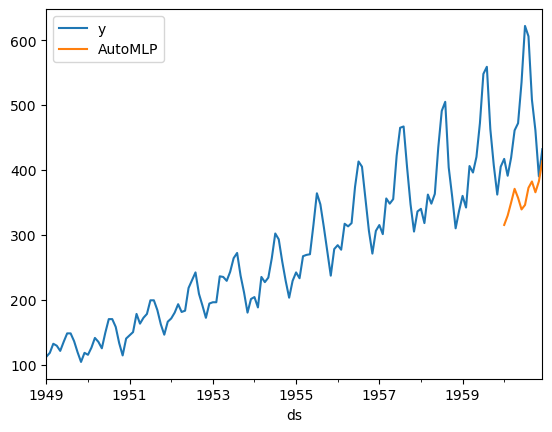

In [14]:
#| hide
Y_test_df['AutoMLP'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

### References
- [James Bergstra, Remi Bardenet, Yoshua Bengio, and Balazs Kegl (2011). "Algorithms for Hyper-Parameter Optimization". In: Advances in Neural Information Processing Systems. url: https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- [Kirthevasan Kandasamy, Karun Raju Vysyaraju, Willie Neiswanger, Biswajit Paria, Christopher R. Collins, Jeff Schneider, Barnabas Poczos, Eric P. Xing (2019). "Tuning Hyperparameters without Grad Students: Scalable and Robust Bayesian Optimisation with Dragonfly". Journal of Machine Learning Research. url: https://arxiv.org/abs/1903.06694](https://arxiv.org/abs/1903.06694)
- [Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, Ameet Talwalkar (2016). "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization". Journal of Machine Learning Research. url: https://arxiv.org/abs/1603.06560](https://arxiv.org/abs/1603.06560)